### Packages

In [1]:
from pathlib import Path
from pydicom import dcmread
import numpy as np
import matplotlib.pyplot as plt

### Preprocessed data

In [2]:
data_path = Path().resolve().parents[1] / "dane" / "KARDIO ZAMKNIETE" / "A001" / "DICOM" / "P1" / "E1" / "S1"

In [3]:
def convert_sequence_to_array(path: Path):
    return np.stack([np.flip(dcmread(file).pixel_array) for file in data_path.iterdir()], axis=0)

In [4]:
stacked = convert_sequence_to_array(data_path)

In [5]:
print(f"Number of images: {stacked.shape[0]}")
print(f"Size of image: {stacked.shape[1]}x{stacked.shape[2]}")

Number of images: 512
Size of image: 512x512


In [32]:
dcmread(next(data_path.glob("*"))).PixelSpacing

[0.402, 0.402]

In [40]:
dcmread(next(data_path.glob("*")))

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 186
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.392.200036.9116.2.2047728388.1656374025.777523.1.328
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.840.113619.6.263
(0002, 0013) Implementation Version Name         SH: 'NUEVO_1_0'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.392.200036.9116.2.2047728388.1656374025.777523.1.328
(0008, 0020) Study Date                          DA: '20220627'
(0008, 0021) Series Date                         D

In [25]:
data_path.

WindowsPath('C:/Users/marci/Desktop/ICM/MGR/dane/KARDIO ZAMKNIETE/A001/DICOM/P1/E1/S1')

### Hounsfield scale

The pixel values of this CT scan are expressed in Hounsfield Units:
$$
HU(x,y) = 1000 \cdot \frac{\mu{(x,y)} - \mu_{water}}{\mu_{water}-\mu_{air}}
$$
where $\mu$ is the attenuation coefficient of the material. The linear attenuation coefficient is defined based on how the intensity of a photon beam decays as it passes a distance $x$ through a material $I=I_{0}e^{-\mu x}$. Note that $\mu$ depends on the energy of the photon beam, and in a CT scan photons usually have energies 100 keV.

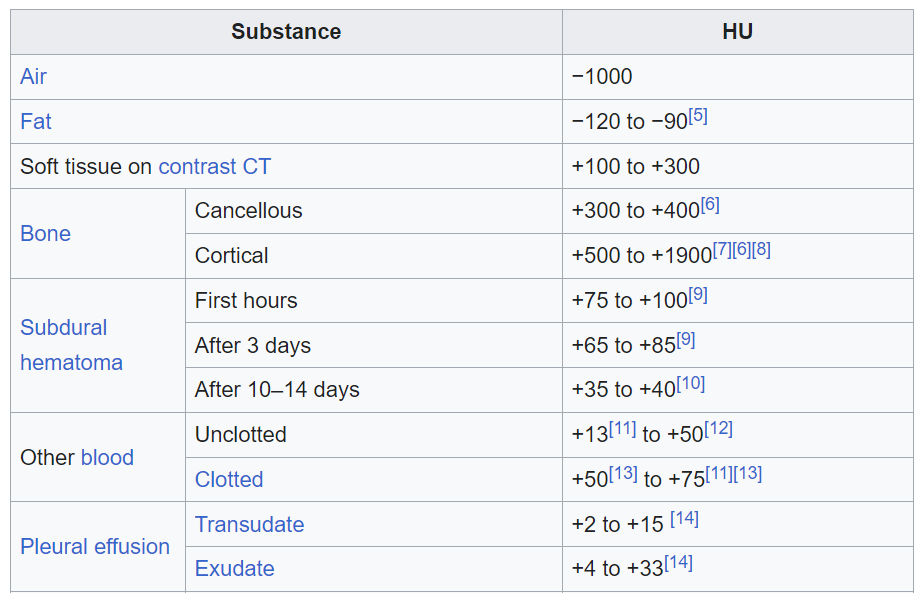

### Histogram of Hounsfield values

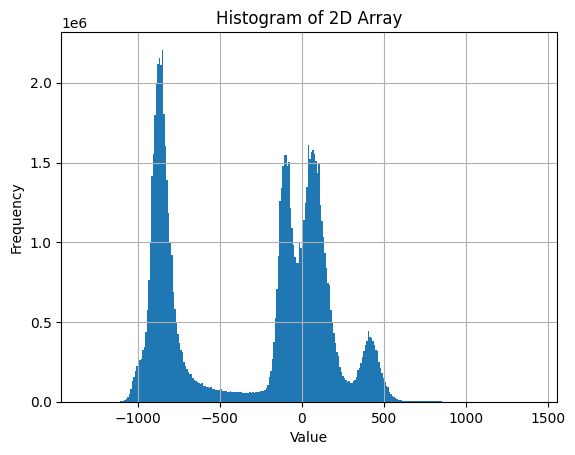

In [14]:
flattened_stacked = stacked.flatten()
flattened_filtered_stacked = flattened_stacked[flattened_stacked > -2000]
hist, bins = np.histogram(flattened_filtered_stacked, bins=300)
plt.hist(flattened_filtered_stacked, bins=300)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of 2D Array')
plt.grid()
plt.show()

### Simple mask segmentation

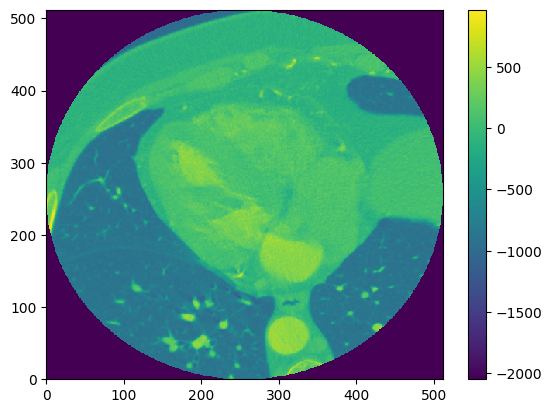

In [15]:
plt.pcolormesh(stacked[0])
plt.colorbar();

In [8]:
stacked_roi = stacked[0].copy()

In [85]:
def select_ROI_array(image, y0, x0, size, num):
    r = np.sqrt((y0-308)**2+(x0-216)**2)
    ROI_array = []
    for i in range(num):
        y = int(r*np.cos((i*2*np.pi)/num)) + 308
        x = int(r*np.sin((i*2*np.pi)/num)) + 216
        ROI_array.append(stacked_roi[y-size//2:y+size//2,x-size//2:x+size//2])
    return ROI_array

In [98]:
ROI_array = select_ROI_array(image=stacked_roi, y0=400, x0=250, size=16, num=32)
print(f"N: {len(ROI_array)} {ROI_array[0].shape}")

N: 32 (16, 16)


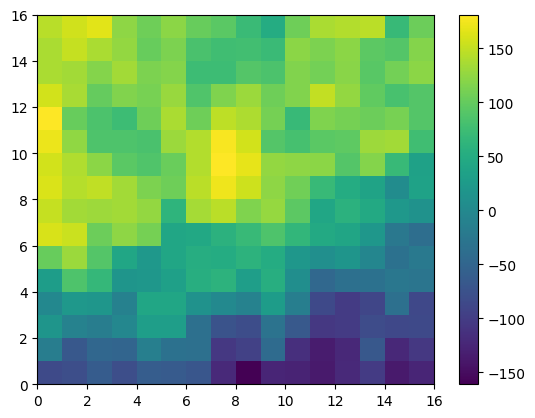

In [99]:
plt.pcolormesh(ROI_array[0])
plt.colorbar();

In [100]:
def calculate_NPS(ROI_array, pixel_size_x, pixel_size_y):
    NPS_array = []
    for roi in ROI_array:
        dft = np.fft.fft2(roi - np.mean(roi))
        shifted_dft = np.fft.fftshift(dft)
        NPS_array.append(np.abs(shifted_dft)**2)
    N = len(NPS_array)
    Ly = NPS_array[0].shape[0]
    Lx = NPS_array[0].shape[1]
    return 1/N*(np.sum(NPS_array,axis=0)*pixel_size_x*pixel_size_y)/(Lx*Ly)
    

In [101]:
NPS = calculate_NPS(ROI_array, 0.402, 0.402)

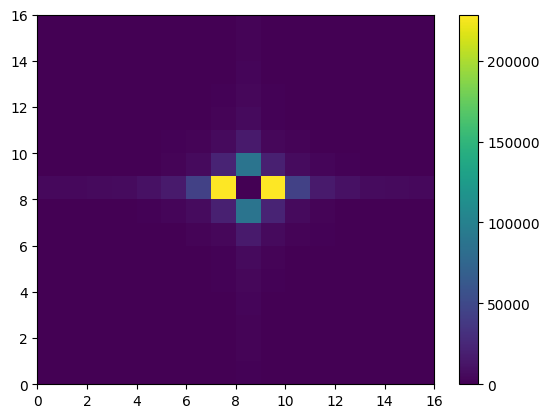

In [102]:
plt.pcolormesh(NPS)
plt.colorbar();

In [103]:
dx = 1
dy = 1
np.sqrt(np.trapz(np.trapz(NPS, dx=dx, axis=1), dx=dy, axis=0))

1033.9808759035448